In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

**Data 불러오기**

In [2]:
train_df = pd.read_csv(r"data\train.csv")
test_df = pd.read_csv(r"data\test.csv")

**0~1로 normalize 하기**

In [3]:
def normalize(df):
    df.iloc[:,1:] = (df.iloc[:,1:]-df.iloc[:,1:].min())/(df.iloc[:,1:].max() - df.iloc[:,1:].min() + 1.0e-9)
    return df
train_df = normalize(train_df)
test_df = normalize(test_df)

**train을 train과 validation으로 분리**

In [4]:
x_train, x_validation, y_train, y_validation = train_test_split(train_df.iloc[:,1:].to_numpy(), train_df.iloc[:,0].to_numpy(),test_size = 0.2, random_state = 10)
x_test = test_df.to_numpy()

**y를 one hot encoding 하기**

In [5]:
def one_hot_encoding(label, size):
    if len(label.shape) >= 2:
        return label
    else:
        y = np.zeros(shape = (len(label), size), dtype = int)
        for i,key in enumerate(label):
            y[i,key] = 1
    return y

In [6]:
size = 10
y_train = one_hot_encoding(y_train, size)
y_validation = one_hot_encoding(y_validation, size)

**Network 구성**
- shape = (row, col)
- Dimension : 0(col 수 만큼 output을 뽑는다), 1(row 수만큼 output을 뽑는다.)
- axis : 0(col 수 만큼 output을 뽑는다), 1(row 수만큼 output을 뽑는다.)

In [11]:
ninputs = 784
noutputs = 10

X = tf.placeholder(shape = [None, ninputs], dtype = tf.float32, name = "input")
Y = tf.placeholder(shape = [None, noutputs], dtype = tf.float32, name = "output")

W0 = tf.Variable(tf.random_normal(shape = [ninputs, ninputs], dtype = tf.float32), name = "weight1")
W1 = tf.Variable(tf.random_normal(shape = [ninputs, noutputs], dtype = tf.float32), name = "weight2")

b0 = tf.Variable(tf.random_normal(shape = [ninputs], dtype = tf.float32), name = "bias1")
b1 = tf.Variable(tf.random_normal(shape = [noutputs], dtype = tf.float32), name = "bias2")


H0 = tf.sigmoid(tf.matmul(X,W0)+b0, name = "layer1")
H1 = tf.sigmoid(tf.matmul(H0, W1)+b1, name = "layer2")

#softmax
softmax = tf.nn.softmax(H1, name = "softmax")

#loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = Y, logits = H1))
optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(loss)

**Accuracy, Predict 만들기**
- 자리 확인이 제일 햇갈린다.!!

In [12]:
predict = tf.arg_max(softmax, 1)
correct = tf.equal(x = predict, y = tf.arg_max(Y, 1)) #1d-array의 maximum 값의 자릿수
accuracy = tf.reduce_mean(tf.cast(correct, dtype = tf.float32))

**Network 동작**

In [13]:
cost_list = []
Acc_train_list = []
Acc_validation_list = []
epoch = 300
step = 30
list_size = 10

sess = tf.Session()
    
sess.run(tf.global_variables_initializer())
        
for i in range(1,epoch+1):
    _, cost, acc_train = sess.run([train, loss, accuracy], feed_dict = {X:x_train, Y:y_train})
    acc_validation = sess.run(accuracy, feed_dict = {X:x_validation, Y:y_validation})
    
    if i%step == 0:
        print("[{}/300] cost : {}, train acc = {}, validation acc = {}".format(i, cost, acc_train, acc_validation))
        print(sess.run(predict, feed_dict = {X:x_train[0].reshape((1,784))}))
        cost_list.append(cost)
        Acc_train_list.append(acc_train)
        Acc_validation_list.append(acc_validation)

[30/300] cost : 2.009464740753174, train acc = 0.3209821283817291, validation acc = 0.32273808121681213
[8]
[60/300] cost : 1.808597445487976, train acc = 0.5022321343421936, validation acc = 0.5082142949104309
[8]
[90/300] cost : 1.6634409427642822, train acc = 0.7534226179122925, validation acc = 0.7448809742927551
[8]
[120/300] cost : 1.6020463705062866, train acc = 0.8442559242248535, validation acc = 0.833809494972229
[4]
[150/300] cost : 1.5717724561691284, train acc = 0.878720223903656, validation acc = 0.8653571605682373
[4]
[180/300] cost : 1.5542831420898438, train acc = 0.8958035707473755, validation acc = 0.8791666626930237
[4]
[210/300] cost : 1.5428662300109863, train acc = 0.9064881205558777, validation acc = 0.8879761695861816
[4]
[240/300] cost : 1.535017728805542, train acc = 0.9141964316368103, validation acc = 0.8965476155281067
[4]
[270/300] cost : 1.529249668121338, train acc = 0.9198511838912964, validation acc = 0.9010714292526245
[4]
[300/300] cost : 1.52482235

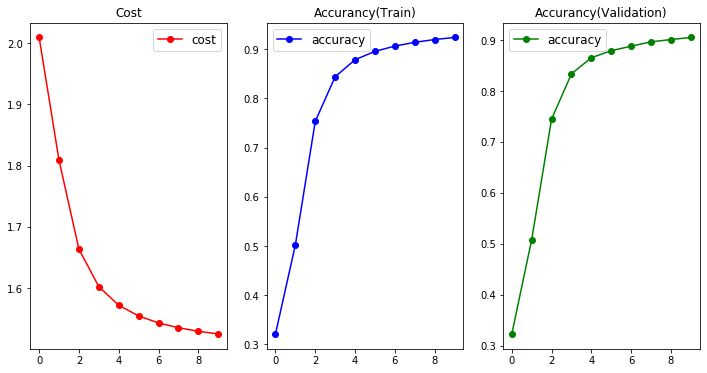

In [31]:
fig = plt.figure(figsize =(12,6))

ax1 = fig.add_subplot(1,3,1)
ax1.plot(cost_list, color = 'red' ,marker = 'o', label = 'cost')
plt.title('Cost')
plt.legend(fontsize=  12)

ax2 = fig.add_subplot(1,3,2)
ax2.plot(Acc_train_list, color = 'blue', marker = 'o', label = 'accuracy')
plt.title('Accurancy(Train)')
plt.legend(fontsize= 12)

ax3 = fig.add_subplot(1,3,3)
ax3.plot(Acc_validation_list, color = 'green', marker = 'o', label = 'accuracy')
plt.title('Accurancy(Validation)')
plt.legend(fontsize = 12)

plt.show()

**test data 예측**

In [47]:
test_pred =  sess.run(predict, feed_dict = {X:x_test})

summit  = pd.read_csv(r'data\sample_submission.csv')
summit['Label'] = test_pred
summit.to_csv(r'data\summit.csv', index = False)